In [1]:
import os
import json
import math
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import matplotlib
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np

import matplotlib.pyplot as plt


### Open image with rasterio:

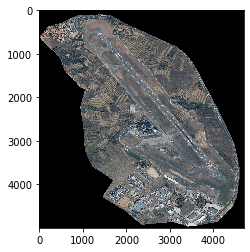

In [2]:
with rasterio.open("/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF/LFMP_ortho.tif") as src:
    img = src.read()
    meta = src.meta

img = reshape_as_image(img)

plt.imshow(img)

### Read Geojson as  a dataframe:

In [3]:
def polygon_df(filepath):
    df = gpd.read_file(filepath)


    df = df.drop(columns=['originated', 'readonly',
           'notvalidated', 'lock', 'elev', 'hacc', 'iata', 'name', 'idarpt',
           'acft', 'idnumber', 'termref', 'pcn', 'restacft', 'status', 'surftype',
           'length', 'width', 'color', 'direc', 'style', 'rwymktyp', 'asda',
           'availPavedSurfFromThr', 'brngmag', 'brngtrue', 'cat', 'ellipse',
           'geound', 'lda', 'rops_landing_length', 'rwyslope', 'tdze', 'tdzslope',
           'thrtype', 'toda', 'tora', 'vasis', 'bridge', 'gsurftyp', 'runwayexit',
           'imagery_date'])
    
    return df[df["geometry"].geom_type == 'Polygon']

#### Only polygon:

In [4]:
features_list = []
for e in df['feattype']:
    if e['value'] not in features_list:
        features_list.append(e['value'])

print(features_list)

NameError: name 'df' is not defined

In [6]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

def create_mask(features_list,src,df):
    im_size = (src.meta['height'], src.meta['width'])
    whole_mask = np.zeros([src.meta['height'],src.meta['width']])

    for i,f in enumerate(features_list):
        poly_shp = []
        data_geom = df[df['feattype'] == {'value': f}].geometry
        for g in data_geom.values:


            poly = poly_from_utm(g, src.meta['transform'])
            poly_shp.append(poly)

            if g.geom_type == 'Polygon':
                poly = poly_from_utm(g, src.meta['transform'])
                poly_shp.append(poly)
            else:
                for p in g:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)


        mask = rasterize(shapes=poly_shp,out_shape=im_size)*color_mapping[f]
        whole_mask = whole_mask + mask
    
    return whole_mask




In [ ]:
outfolder = "/Users/salimbaddou/PIE"  #folder where the mask is stored
os.makedirs(outfolder, exist_ok=True)

In [7]:
color_mapping = {
    'Apron.apronelement': 10,
    'Runway.runwayelement': 20,
    'Runway.runwaymarking': 30,
    'TouchDownLiftOffArea.touchdownliftoffarea': 40
}

In [8]:
features_list = ['Apron.apronelement','Runway.runwayelement','Runway.runwaymarking']

In [47]:
import os

directory = os.fsencode("/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF")

for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename.endswith(".tif"):
        print(filename)
        with rasterio.open("/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF/{}".format(filename)) as src:
            img = src.read()
            meta = src.meta
        
            filepath = '/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoJSON/product_ADBLucem_{}.json'.format(filename.split('_')[0])
        try:   
            df = polygon_df(filepath)
            whole_mask = create_mask(features_list,src,df)
            a = whole_mask
            
            matplotlib.image.imsave('mask_{}.jpg'.format(filename.split('_')[0]), whole_mask)
            print("image saved")
            
        except:
            pass
    


VHHH_ortho.tif
image saved
LFMP_ortho.tif
image saved
VIDN_ortho.tif
LIRP_ortho.tif
DNMM_ortho.tif
image saved


In [36]:
img = rasterio.open('/Users/salimbaddou/PIE/pie-repo/mask_LFMP.jpg')

                   

/Users/salimbaddou/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [46]:
img.read()[1][:100][:100]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)